First lets get the data we previously clean and feature engineered.

1. Click on the folder icon on the left bar <--
2. If you're not connected to a host, wait for Colab to connect you to a host
3. Click on the file upload icon (file with arrow up icon) and upload your `diabetes.parquet`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/NUS/CitiDev/ML/data/diabetes.parquet /content/

In [ ]:
drive.flush_and_unmount()

## Installing Packages

In [ ]:
!pip install deap update_checker tqdm stopit xgboost

     |████████████████████████████████| 163kB 5.8MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11957 sha256=52ce2a78949f0905cae5423f8325e0b77042841531be8b992d65c16d612c4034
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [ ]:
!pip install distributed>=2.10.0

In [ ]:
!pip install distributed>=2.10.0 dask[delayed] dask[dataframe] dask-ml fsspec>=0.3.3 

ERROR: distributed 2021.1.1 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 which is incompatible.


In [ ]:
!pip install -q featuretools

     |████████████████████████████████| 296kB 5.6MB/s 


In [ ]:
!pip install --no-deps -q datawig
!pip install -q mxnet-mkl

     |████████████████████████████████| 76.7MB 119kB/s 


In [ ]:
!pip install skl2onnx

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 14.5MB 245kB/s 


In [ ]:
!pip install tpot

     |████████████████████████████████| 92kB 3.8MB/s 
     |████████████████████████████████| 157.5MB 72kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


# Automated Machine Learning

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import datawig

# Data Loading and Preparation
Reading raw data and performing scaling

In [ ]:
# Raw data
url = "https://raw.githubusercontent.com/KuangHao95/citizen_material/main/diabetes_raw.csv"
cols = ['preg', 'glu', 'pres', 'skin', 'insulin', 'bmi', 'func', 'age', 'class']
df = pd.read_csv(url, names=cols)

# We will use the auto-imputation result
df_imputed = datawig.SimpleImputer.complete(df)
df_imputed.head(2)
X = df_imputed.iloc[:,0:8]  # raw features
Y = df_imputed.iloc[:,8]    # target column

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

# normalization
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=df_imputed.columns[:8])

# Auto Feature Engineering

In [ ]:
import featuretools as ft

# Load the dataset
es = ft.EntitySet(id='diabetes')
es.entity_from_dataframe(entity_id='data', dataframe=X_train, index='index')

/usr/local/lib/python3.6/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: diabetes
  Entities:
    data [Rows: 614, Columns: 9]
  Relationships:
    No relationships

In [ ]:
# Run Deep Feature Synthesis to generate new features
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity='data',
                                      trans_primitives=['add_numeric', 'multiply_numeric'],
                                      drop_contains=['class'],  # drop target column
                                      max_depth=1,
                                      features_only=False,
                                      verbose=True)

Built 64 features
Elapsed: 00:00 | Progress: 100%|██████████


## Add PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=7).fit(feature_matrix)
X_train = pca.transform(feature_matrix)

Now our data dataframe only contains the features.

# AutoML

We will be using the TPOTClassifier as we will be training a classification model

In [ ]:
from tpot import TPOTClassifier

TPOT uses a genetic algorithm for pipeline/algorithm search.

`generations` and `population_size` are parameters for the genetic algorithm.

`cv` [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is for model validation/evaluation while training. You do not need a validation set if you're using cross validation.

![8](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/LOOCV.gif/450px-LOOCV.gif)

In [ ]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

In [ ]:
pipeline_optimizer.fit(X_train, Y_train)


Generation 1 - Current best internal CV score: 0.7703851792616286

Generation 2 - Current best internal CV score: 0.7703851792616286

Generation 3 - Current best internal CV score: 0.7703851792616286

Generation 4 - Current best internal CV score: 0.7784886045581768

Generation 5 - Current best internal CV score: 0.7784886045581768

Best pipeline: GradientBoostingClassifier(SelectPercentile(input_matrix, percentile=89), learning_rate=0.5, max_depth=1, max_features=0.4, min_samples_leaf=11, min_samples_split=6, n_estimators=100, subsample=0.6000000000000001)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

When a best pipeline has been found, you can export the code for the pipeline to a python `.py` file.

In [ ]:
pipeline_optimizer.export('tpot_exported_pipeline.py')

Let's take a look at the export python code.

In [ ]:
!cat tpot_exported_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.7784886045581768
exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=89),
    GradientBoostingClassifier(learning_rate=0.5, max_depth=1, max_features=0.4, min_samples_leaf=11, min_samples_split=6, n_estimators=100, subsample=0.6000000000000001)
)
#


You would have to modify the data loading and reading lines in the exported python script.

## Export trained pipeline to file 

What do you do next with the exported python script?

In [ ]:
import joblib

In [ ]:
joblib.dump(pipeline_optimizer.fitted_pipeline_, "tpot_pipeline.joblib.bz2")

['tpot_pipeline.joblib.bz2']

Export `feature_defs` and fitted `scaler` and `pca`

In [ ]:
joblib.dump(scaler, "scaler.joblib.bz2")
joblib.dump(feature_defs, "feature_defs.joblib.bz2")
joblib.dump(pca, "fitted_pca.joblib.bz2")

['fitted_pca.joblib.bz2']

# Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt

### Load Saved pipelines and models
Let's load out saved fitted pipeline and feature engineering models

In [ ]:
automl_pipeline = joblib.load("tpot_pipeline.joblib.bz2")
fitted_scaler = joblib.load("scaler.joblib.bz2")
ft_feature_defs = joblib.load("feature_defs.joblib.bz2")
fitted_pca = joblib.load("fitted_pca.joblib.bz2")

### Feature Engineering for test set

In [ ]:
# Scaling
X_test = pd.DataFrame(fitted_scaler.transform(X_test), columns=df_imputed.columns[:8])

# Transform on test set
es_test = ft.EntitySet(id='diabetes')
es_test.entity_from_dataframe(entity_id='data', dataframe=X_test, index='index')
test_matrix = ft.calculate_feature_matrix(features=ft_feature_defs, entityset=es_test)

# PCA Dim reduction
X_test = fitted_pca.transform(test_matrix)

/usr/local/lib/python3.6/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


### Inference on test set

In [ ]:
y_pred = automl_pipeline.predict(X_test)
class_names = Y_test.unique()

## Accuracy

Accuracy classification score.

In binary and multiclass classification, this function is equal to the jaccard_score function.

It can be applied to most generic problems but is not very useful when it comes to unbalanced datasets. 

For instance, if we are detecting frauds in bank data, the ratio of fraud to non-fraud cases can be 1:99. In such cases, if accuracy is used, the model will turn out to be 99% accurate by predicting all test cases as non-fraud. The 99% accurate model will be completely useless.

If a model is poorly trained such that it predicts all the 1000 (say) data points as non-frauds, it will be missing out on the 10 fraud data points. If accuracy is measured, it will show that that model correctly predicts 990 data points and thus, it will have an accuracy of (990/1000)*100 = 99%! 

This is why accuracy is a false indicator of the model’s health.

Therefore, for such a case, a metric is required that can focus on the ten fraud data points which were completely missed by the model.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(Y_test,y_pred,)

0.7337662337662337

## Precision

Precision is the metric used to identify the correctness of classification.

![pr](https://latex.codecogs.com/png.latex?%5Cdpi%7B120%7D%20%5CLARGE%20Precision%20%3D%20TP%20/%20%28TP%20+%20FP%29)

Intuitively, this equation is the ratio of correct positive classifications to the total number of predicted positive classifications. The greater the fraction, the higher is the precision, which means better is the ability of the model to correctly classify the positive class.

In the problem of predictive maintenance (where one must predict in advance when a machine needs to be repaired), precision comes into play. The cost of maintenance is usually high and thus, incorrect predictions can lead to a loss for the company. In such cases, the ability of the model to correctly classify the positive class and to lower the number of false positives is paramount!



In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision_score(Y_test, y_pred)

0.6296296296296297

## Recall

Recall tells us the number of positive cases correctly identified out of the total number of positive cases. 

![recall](https://latex.codecogs.com/png.latex?%5Cdpi%7B120%7D%20%5CLARGE%20Recall%20%3D%20TP%20/%20%28TP%20+%20FN%29)

Going back to the fraud problem, the recall value will be very useful in fraud cases because a high recall value will indicate that a lot of fraud cases were identified out of the total number of frauds.

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
recall_score(Y_test, y_pred)

0.6181818181818182

## Precision Recall Curve

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

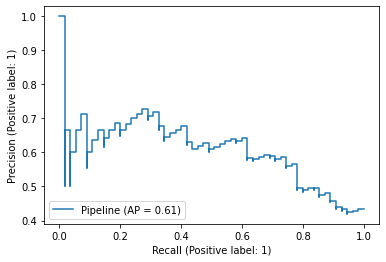

In [ ]:
plot_precision_recall_curve(automl_pipeline, X_test, Y_test)

## F1 Score

F1 score is the harmonic mean of Recall and Precision and therefore, balances out the strengths of each. 

It is useful in cases where both recall and precision can be valuable – like in the identification of plane parts that might require repairing. Here, precision will be required to save on the company’s cost (because plane parts are extremely expensive) and recall will be required to ensure that the machinery is stable and not a threat to human lives.

![](https://latex.codecogs.com/png.latex?%5Cinline%20%5Cdpi%7B120%7D%20%5Clarge%20F1%20Score%20%3D%202*%28%28precision*recall%29/%28precision+recall%29%29)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(Y_test, y_pred)

0.6238532110091743

## Confusion Matrix

For every classification model prediction, a matrix called the confusion matrix can be constructed which demonstrates the number of test cases correctly and incorrectly classified. 

It looks something like this (considering 1 -Positive and 0 -Negative are the target classes):

|	|Actual 0 |	Actual 1|
|---|-------|----------|
|Predicted 0| True Negatives (TN) |	False Negatives (FN)|
|Predicted 1| False Positives (FP)| True Positives (TP)|

    TN: Number of negative cases correctly classified
    TP: Number of positive cases correctly classified
    FN: Number of positive cases incorrectly classified as negative
    FP: Number of negative cases correctly classified as positive

In [ ]:
from sklearn.metrics import plot_confusion_matrix

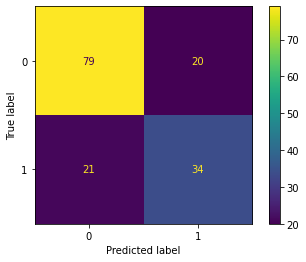

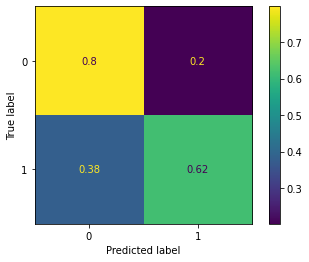

In [ ]:

plot_confusion_matrix(automl_pipeline, X_test, Y_test)

plot_confusion_matrix(automl_pipeline, X_test, Y_test, normalize='true')

## Plot ROC Curve

In [ ]:
from sklearn.metrics import plot_roc_curve

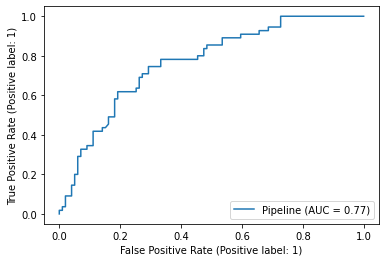

In [ ]:
plot_roc_curve(automl_pipeline, X_test, Y_test) 

# End to End Pipeline

## Define ClassifcationModel Class

In [ ]:
import featuretools as ft
import joblib

class ClassificationModel():

  def __init__(self):
    self.automl_pipeline = joblib.load("tpot_pipeline.joblib.bz2")
    self.fitted_scaler = joblib.load("scaler.joblib.bz2")
    self.ft_feature_defs = joblib.load("feature_defs.joblib.bz2")
    self.fitted_pca = joblib.load("fitted_pca.joblib.bz2")
    self.cols = ['preg', 'glu', 'pres', 'skin', 'insulin', 'bmi', 'func', 'age']

  def transform(self, X_test):
    # Scaling
    X_test = pd.DataFrame(self.fitted_scaler.transform(X_test), columns=self.cols)

    # Transform on test set
    es_test = ft.EntitySet(id='diabetes')
    es_test.entity_from_dataframe(entity_id='data', dataframe=X_test, index='index')
    test_matrix = ft.calculate_feature_matrix(features=self.ft_feature_defs, entityset=es_test)

    # PCA Dim reduction
    X_test = self.fitted_pca.transform(test_matrix)
    return X_test

  def run_inference(self, X_test):
    transformed_data = self.transform(X_test)
    y_pred = automl_pipeline.predict(transformed_data)
    return y_pred

## Run inference with the End to End pipeline

In [ ]:
payload = pd.DataFrame([[  2.  , 112.  ,  75.  ,  32.  ,   0.  ,  35.7 ,   0.15,  21.  ]]) # first entry in X_test
cm = ClassificationModel()
#cm.transform(payload)
y_pred = cm.run_inference(payload)

/usr/local/lib/python3.6/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


### Compare results

In [ ]:
_, x_test, _, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [ ]:
y_pred, y_test.iloc[1]

(array([0]), 0)

In [ ]:
data = cm.transform(x_test)

/usr/local/lib/python3.6/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


# Storing models in Redis

In [ ]:
!git clone https://github.com/seppo0010/rlite.git

Cloning into 'rlite'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 4886 (delta 0), reused 1 (delta 0), pack-reused 4881
Receiving objects: 100% (4886/4886), 1.24 MiB | 12.55 MiB/s, done.
Resolving deltas: 100% (3697/3697), done.


In [ ]:
!cd rlite && make all

In [ ]:
!pip install hirlite

     |████████████████████████████████| 296kB 5.5MB/s 
  Created wheel for hirlite: filename=hirlite-0.3.1-cp36-cp36m-linux_x86_64.whl size=765808 sha256=398afc68c29b8cfd99308d5ec326b4f43b6fa4ffa30fc7218270253ce209a564
  Stored in directory: /root/.cache/pip/wheels/49/4e/77/5bed67225519bccf23ad3c52d2dfdd6e50ee7020ebbf21d86b
Successfully built hirlite


In [ ]:
import hirlite
import zlib
import pickle

In [ ]:
rlite = hirlite.Rlite(path='mydb.rld')

In [ ]:
rlite.command('set', 'automl_pipeline', zlib.compress(pickle.dumps(cm.automl_pipeline)))
rlite.command('set', 'scaler', zlib.compress(pickle.dumps(cm.fitted_scaler)))
rlite.command('set', 'pca', zlib.compress(pickle.dumps(cm.fitted_pca)))
rlite.command('set', 'feature_defs', zlib.compress(pickle.dumps(cm.ft_feature_defs)))

True

In [ ]:
pickle.loads(zlib.decompress(rlite.command('get', 'automl_pipeline')))

Pipeline(steps=[('selectpercentile', SelectPercentile(percentile=89)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=1,
                                            max_features=0.4,
                                            min_samples_leaf=11,
                                            min_samples_split=6,
                                            random_state=42,
                                            subsample=0.6000000000000001))])